In [1]:
# A few imports
import yt
import numpy as np
import trident
import matplotlib.pyplot as pl
from yt.units import kpc,mp
from yt.fields.particle_fields import add_volume_weighted_smoothed_field

In [2]:
%%time
# Import some FIRE2 data
fname = '/mnt/raid-project/murray/lakhlani/FIRE2_core/m12c_res56000/output/snapshot_600.hdf5'
ds = yt.load(fname)
# The center of the Halo was recovered in another notebook
center_Halo = [25277.66673046,34505.21241664,32868.48520185]
sp = ds.sphere(center_Halo, (10, "kpc"))
ang_mom_sphere = ds.sphere(center_Halo, (0.5, "kpc"))

yt : [INFO     ] 2020-05-19 09:35:53,880 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2020-05-19 09:35:53,882 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2020-05-19 09:35:53,933 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2020-05-19 09:35:53,935 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-05-19 09:35:53,936 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-05-19 09:35:53,938 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2020-05-19 09:35:53,940 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05-19 09:35:53,941 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2020-05-19 09:35:53,942 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2020-05-19 09:35:53,944 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2020-05-19 09:35:53,945 Parameters: omega_radiation           = 0.

CPU times: user 11 s, sys: 3.83 s, total: 14.8 s
Wall time: 15.1 s


In [3]:
def find_normal_vector():
    # Finds the galaxy's normal vector by averaging the angular momentas
    # of the particles
    angular_momentum =[np.mean(ang_mom_sphere['angular_momentum_x']),
                       np.mean(ang_mom_sphere['angular_momentum_y']),
                       np.mean(ang_mom_sphere['angular_momentum_z'])]
    normalized_ang = np.array(angular_momentum)/angular_momentum[0]
    print(normalized_ang)

In [4]:
# Define a few vectors. parr is along the galaxy plane. 
# Perp is perpendicular to the galaxy plane
perp = np.array([1.,-0.23746973,-0.36259271])
parr = np.array([1,1,2.10299393498])
norm_perp = tuple(perp/np.linalg.norm(perp))
norm_parr = tuple(parr/np.linalg.norm(parr))

In [5]:
# Creates the field which will be required to compute the dispersion measure
def _ElectronDensity(field, data):
    xh= 1. - data['PartType0','Metallicity_00'] - data['PartType0','Metallicity_01']
    ne= xh * data['PartType0','Density'] * data['PartType0','ElectronAbundance'] / mp
    return ne
# Adds the field to the data set
ds.add_field(('PartType0', '_ElectronDensity'), function = _ElectronDensity, 
             sampling_type = 'particle', units='1/cm**3')

# smooths a particle field into a continuous field
fn = add_volume_weighted_smoothed_field(
      "PartType0", "particle_position", "particle_mass", "smoothing_length",
      "density", "_ElectronDensity",ds.field_info)

# Labels the new field
ds.field_info.alias(('gas', '_ElectronDensity'), fn[0])
ds.derived_field_list.append(('gas', '_ElectronDensity'))

In [19]:
def make_ray_plots(perp, parr, filename, all_angles = False):
    ''' 
    This function computes the dispersion measure along a light ray
    going through a simulated galaxy.
    Arguments:
    perp: vector perpendicular to the light ray used to make a projection plot
    parr: vector parallel to the light ray
    filename: name inditifer for images
    all_angles: Instead of creating a single off-axis projection plot,
    the function creates three on-axis projection plots when True
    '''
    
    # RAY CREATION
    ray_end = list(np.array(center_Halo) + 4*np.array(parr))
    ray = trident.make_simple_ray(ds,
                                   start_position=center_Halo,
                                    end_position=ray_end,
                                    fields = ['_ElectronDensity','density','temperature'],
                                    data_filename="{}.h5".format(filename))
    
    # GALAXY PLOTS
    if all_angles:
        # Creates three on-axis projection plots
        axes=['x','y','z']
        for axis in axes:
            prj_x = yt.ProjectionPlot(ds, axis, 'density', width=5*kpc, data_source = sp,
                                      center=center_Halo)
            prj_x.annotate_ray(ray)
            prj_x.save(filename+'_galaxy_{}.pdf'.format(str(axis)))
        
    else:
        image = yt.OffAxisProjectionPlot(ds, perp, fields= 'density', center= center_Halo, 
                                     width=5, data_source = sp)
        image.annotate_ray(ray)
        image.save(filename+'_galaxy.pdf')
    
        # COMPUTING THE DM
        length = np.linalg.norm(np.array(center_Halo)-np.array(ray_end))
        int_elec_dens = []
        int_total = 0
        increment = length/len(ray.data['_ElectronDensity'])
        # Finding the entry where arc_length>1kpc:
        for i in range(len(ray.data['_ElectronDensity'])):
            # Convert in pc/cm^-3
            int_total += ray.data['_ElectronDensity'][i]*increment*1000
            int_elec_dens.append(float(int_total))
        
        # LIGHT RAY DATA PLOTS
        fig, axs = pl.subplots(2,2)

        axs[0,0].plot(np.linspace(0,length,len(ray.data['density'])), 
                      np.log10(ray.data['density']))
        axs[0,0].set_xlabel('Arc Length (kpc)')
        axs[0,0].set_ylabel('Density '+r'$\log\left(\frac{g}{cm^3}\right)$')

        axs[0,1].plot(np.linspace(0,length,len(ray.data['temperature'])), 
                      np.log10(ray.data['temperature']))
        axs[0,1].set_xlabel('Arc Length (kpc)')
        axs[0,1].set_ylabel('Temperature '+r'$\log(K)$')

        axs[1,0].plot(np.linspace(0,length,len(ray.data['_ElectronDensity'])), 
                np.log10(ray.data['_ElectronDensity']))
        axs[1,0].set_xlabel('Arc Length (kpc)')
        axs[1,0].set_ylabel('Electron Density '+r'$\log(cm^{-3})$')

        axs[1,1].plot(np.linspace(0,length,len(int_elec_dens)), np.log10(int_elec_dens))
        axs[1,1].set_xlabel('Arc Length (kpc)')
        axs[1,1].set_ylabel('DM '+r'$\log(cm^{-2})$')

        pl.subplots_adjust(left = 0.20,right = 0.9,bottom = 0.2,top = 0.9,
                           wspace = 0.4,hspace = 0.8)
        fig.savefig(filename+'_subplots.pdf')

yt : [INFO     ] 2020-05-19 12:55:56,762 Getting segment at z = 0.0: [0.42129445 0.57508687 0.54780809] unitary to [0.42132075 0.57511318 0.54786341] unitary.
yt : [INFO     ] 2020-05-19 12:55:56,766 Getting subsegment: [0.4212944455076667 unitary, 0.5750868736106668 unitary, 0.5478080866975 unitary] to [0.4213207514498732 unitary, 0.5751131795528732 unitary, 0.5478634079344141 unitary].
yt : [INFO     ] 2020-05-19 13:00:35,601 Saving field data to yt dataset: ray_parr.h5.
yt : [INFO     ] 2020-05-19 13:00:35,941 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2020-05-19 13:00:35,942 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-05-19 13:00:35,944 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2020-05-19 13:00:35,945 Parameters: domain_right_edge         = [60000. 60000. 60000.] code_length
yt : [INFO     ] 2020-05-19 13:00:35,947 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05

yt : [INFO     ] 2020-05-19 13:01:52,104 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,125 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,142 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,162 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,180 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,197 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,213 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,231 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,254 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,278 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,296 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,317 Returning an all_data data container.
yt : [INFO     ] 2020-05-19 13:01:52,341 Returning a

CPU times: user 3min 25s, sys: 2min 9s, total: 5min 35s
Wall time: 5min 57s


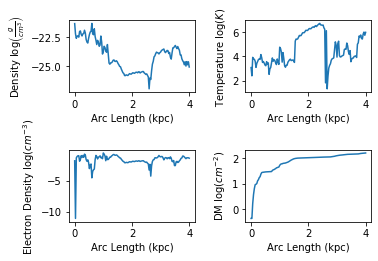

In [20]:
%%time
make_ray_plots(norm_perp, norm_parr, 'ray_parr')

In [ ]:
%%time
make_ray_plots(norm_parr, norm_perp, 'ray_perp')

yt : [INFO     ] 2020-05-19 13:01:54,704 Getting segment at z = 0.0: [0.42129445 0.57508687 0.54780809] unitary to [0.42135561 0.57507235 0.54778591] unitary.
yt : [INFO     ] 2020-05-19 13:01:54,708 Getting subsegment: [0.4212944455076667 unitary, 0.5750868736106668 unitary, 0.5478080866975 unitary] to [0.4213556136279367 unitary, 0.5750723480336616 unitary, 0.5477859075830057 unitary].
